In [246]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
import matplotlib.cm as cm
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size']=20
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import expm
from numpy.linalg import matrix_power
import numba
from numba.types import *
from numba import prange

In [247]:
S=10
dim=int(2*S+1)
basis = np.identity(dim)
i=complex(0,1)

In [248]:
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, parallel=False)
def S_p(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 2*S:
        coef=0
        return (coef, ket_out)
    else:
        coef=np.sqrt(S*(S+1)-m*(m+1))
        ket_out[site+1]= 1
        return (coef, ket_out)
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, parallel=False)
def S_m(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 0:
        coef=0
        return (coef, ket_out)
    else:
        coef= np.sqrt(S*(S+1)-m*(m-1))
        ket_out[site-1]= 1
        return (coef, ket_out)
@numba.jit(float64(float64[:], float64[:]), nopython=True, parallel=False)
def braket(bra, ket):
    if np.all(bra== ket):
        return 1
    else:
        return 0
@numba.jit(complex128[:,:](float64[:, :], float64), nopython=True, parallel=False)
def Compute_Sx(basis, S):
    dim=int(2*S+1)
    Sx=np.zeros((dim, dim), dtype=complex128)
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sx[j, k]=(coef_p*result_p+ coef_m*result_m)/2
    return Sx

@numba.jit(complex128[:,:](float64[:, :], float64), nopython=True, parallel=False)
def Compute_Sy(basis, S):
    dim=int(2*S+1)
    Sy=np.zeros((dim, dim), dtype=complex128)
    i=complex(0,1)
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sy[j, k]=-i*(coef_p*result_p- coef_m*result_m)/2
    return Sy

@numba.jit(complex128[:,:](float64), nopython=True, parallel=False)
def Compute_Sz(S):
    dim=int(2*S+1)
    Sz=np.zeros((dim, dim), dtype=complex128)
    for j in range(dim):
        m=j-S
        Sz[dim-1-j, dim-1-j]=m
    return Sz

LOOKUP_TABLE = np.array([
    1, 1, 2, 6, 24, 120, 720, 5040, 40320,
    362880, 3628800, 39916800, 479001600,
    6227020800, 87178291200, 1307674368000,
    20922789888000, 355687428096000, 6402373705728000,
    121645100408832000, 2432902008176640000], dtype='int64')

@numba.jit(float64(int64), nopython=True, parallel=False)
def fast_log_factorial(n):
    if n<20:
        return np.log(LOOKUP_TABLE[n])
    else:
        #stirling approx
        return n*np.log(n)-n+ 0.5*np.log(2*np.pi*n)
        #return n*np.log(n)-n+ 0.5*np.log(2*np.pi*n)+ 1/(12*n)-1/(360*n**3)
#Take into account that z is complex
@numba.jit(complex128[:](float64, float64, float64), nopython=True, parallel=False)
def define_zeta(S, theta, phi):
    z=np.exp(i*phi)*np.tan(theta/2)
    dim=int(2*S+1)
    ket_z=np.zeros(dim, dtype=complex128)
    for k in range(dim):
        m=k-S
        aux1=fast_log_factorial(int(2*S)) #aux1= log((2S)!)
        aux2=fast_log_factorial(int(S+m)) #aux2= log((S+m)!)
        aux3=fast_log_factorial(int(S-m)) #aux3= log((S-m)!)
        #ket_z[j]=np.sqrt(aux1/(aux2*aux3))*z**(S+m)/(1 + (np.abs(z))**2)**S
        #To deal with big numbers we introduce the log
        #of the factorial, compute the division of them and afterwards we exponentiate
        ket_z[k]=np.exp((aux1-aux2-aux3)/2)*z**(S+m)/((1 + (np.abs(z))**2)**S)
    norm= np.sqrt(np.conjugate(ket_z)@ket_z)
    return ket_z/norm
@numba.jit(complex128[:,:](complex128[:], complex128[:]), nopython=True, parallel=False)
def ketbra(ket, bra):
    dim=len(ket)
    res=np.zeros((dim, dim), dtype=complex128)
    for j in range(dim):
        for k in range(dim):
            res[j,k]=ket[j]*np.conjugate(bra[k])
    return res

In [249]:
def computeQ(rho, ket_th_ph, nt, nphi):
    Q=np.zeros((nt, nphi))
    for j in range(nt):
        for k in range(nphi):
            Q[j, k]=np.real(np.conj(ket_th_ph[j,k, :])@rho@ket_th_ph[j,k,:]*(2*S+1)/(4*np.pi))
    return Q

In [250]:
Sx=np.zeros((dim, dim), dtype=complex)
Sy=np.zeros((dim, dim), dtype=complex)
Sz=np.zeros((dim, dim), dtype=complex)
Sx=Compute_Sx(basis, S)
Sy=Compute_Sy(basis, S) #I've checked that for S=1/2, 1, 3/2 the results are the expected ones
Sz=Compute_Sz(S)

In [251]:
p=np.pi/2
k=10
U=expm(- i*k*Sz@Sz/(2*S))@expm(-i*p*Sy)
Uinv=expm(i*p*Sy)@expm(i*k*Sz@Sz/(2*S))
theta_coh=1
phi_coh=1.3

In [252]:
psi0=define_zeta(S, theta_coh, phi_coh)
#psi0=define_zeta_alt(theta_coh, phi_coh, dim, Sx, Sy, i)
rho0=ketbra(psi0, psi0)
rho_t=rho0
n_theta=100
n_phi=2*n_theta
epsilon=1e-3 #tan(theta/2) diverges for theta=pi so we need to substract a bit
theta_arr=np.linspace(0, np.pi-epsilon, n_theta)
phi_arr=np.linspace(0, 2*np.pi, n_phi)
Ph, Th=np.meshgrid(phi_arr, theta_arr)
coh_states=np.zeros((n_theta, n_phi, dim), dtype=complex)
#Q_t=np.zeros((n_theta, n_phi, n_t))
for j in range(n_theta):
    for k in range(n_phi):
        coh_states[j,k,:]=define_zeta(S, theta_arr[j], phi_arr[k])
        #coh_states[j,k,:]=define_zeta_alt(theta_arr[j], phi_arr[k], dim, Sx, Sy, i)
        
Q_0=computeQ(rho0, coh_states, n_theta, n_phi)

Husimi Q Function for the initial state

In [253]:
def plotQ(Q, label):
    fig, (ax1, ax2)=plt.subplots(1, 2, sharey=True, figsize=[10,4])
    #plt.contourf(Th, Ph, Q_0)
    sc1=ax1.scatter(np.cos(Ph[Ph<np.pi])*np.sin(Th[Ph<np.pi]), np.cos(Th[Ph<np.pi]),c= Q[Ph<np.pi], vmin=0, vmax=np.nanmax(Q))
    sc2=ax2.scatter(np.cos(Ph[Ph>np.pi])*np.sin(Th[Ph>np.pi]), np.cos(Th[Ph>np.pi]),c= Q[Ph>np.pi], vmin=0, vmax=np.nanmax(Q))
    plt.subplots_adjust(wspace=0)
    cb=plt.colorbar(sc1)
    cb.set_label(label)
    ax1.set_xlim(-1, 1)
    ax2.set_xlim(-1, 1)
    ax1.axis('square')
    ax2.axis('square')
    ax1.set_xlabel(r"$\cos \phi \sin \theta$")
    ax1.set_ylabel(r"$\cos \theta$")
    ax2.set_xlabel(r"$\cos \phi \sin \theta$")
    ax1.text(0.65,0.9, "$Y>0$")
    ax2.text(0.65,0.9, "$Y<0$")
    plt.show()

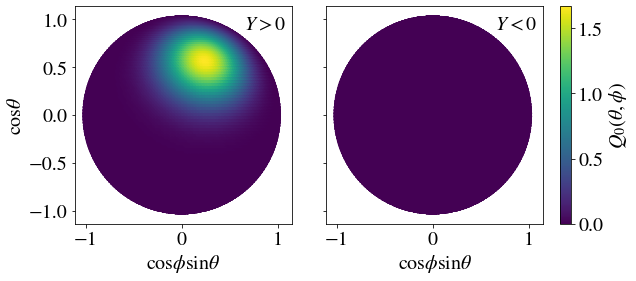

In [254]:
plotQ(Q_0, r"$Q_0(\theta, \phi)$")

In [255]:
#Q function for the evolved state
"""N_periods=100
U_F=matrix_power(U, N_periods)
Uinv_F=matrix_power(Uinv, N_periods)
rho_T=U_F@rho0@Uinv_F
Q_T=computeQ(rho_T, coh_states, n_theta, n_phi)"""

'N_periods=100\nU_F=matrix_power(U, N_periods)\nUinv_F=matrix_power(Uinv, N_periods)\nrho_T=U_F@rho0@Uinv_F\nQ_T=computeQ(rho_T, coh_states, n_theta, n_phi)'

In [256]:
#Acumulated Q function over the whole evolution
N_p=200
rhot=rho0
Qacum=np.zeros((n_theta, n_phi))
for j in range(N_p):
    Qacum+=computeQ(rhot, coh_states, n_theta, n_phi)
    rhot=U@rhot@Uinv

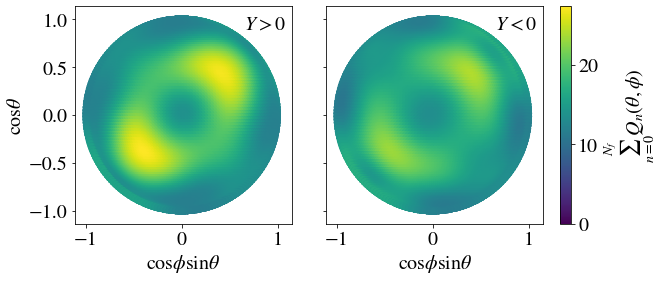

In [257]:
plotQ(Qacum, r"$\sum_{n=0}^{N_f} Q_n(\theta, \phi)$")